In [ ]:
function ResultsV01( PATHVOLTAGE::String, Variables::Dict{Any, Any}, nbins::Int64, limupper::Real,
limite::Real )
    nChs = Variables[ "nChs" ];
    channels = collect( 1:nChs );
    ACD = zeros( nChs, nbins );
    ChannelsStimulo = zeros( nChs, nbins );
    nValores = zeros( nChs, nbins );
    stds = zeros( nChs, nbins );
    maximous = zeros( nChs, nbins );
    earths = zeros( nbins );
    DiscardedChannelsAll = zeros( nChs, nbins );
    ChannelsAfected = zeros( nChs, nbins );
    nzeros = length( string( nbins ) );
    for n = 1:nbins;
        BIN = OneSegment( Variables, n, nbins );
        limlower = ceil( Int, size( BIN, 1 )/8 );
        binname = joinpath( PATHVOLTAGE, string( "BIN", lpad( n, nzeros, "0" ), ".jld" ) );
        BIN = Digital2Analogue( Variables, BIN );
        earth, DiscardedChannels, BIN = DesatNegativePositive( limite, BIN );
        AUX = findall( BIN .== maximum( BIN ) );
        AUX = getindex.( AUX, [ 1 2 ] );
        RepetiveFrames = countmap( AUX[ :, 2 ] );
        V = Int.( values( RepetiveFrames ) );
        K = Int.( keys( RepetiveFrames ) );
        StimArt = K[ V .== maximum( V ) ];
        RepetiveChannels = AUX[ :, 1 ];
        ChannelsArt = RepetiveChannels[ AUX[ :, 2 ] .== StimArt[ 1 ] ];
        Wstd = log.( std( BIN, dims = 2 ) );
        UniqueValues = [ ];
        Variability = [ ];
        for i in channels
            x = unique( BIN[ i, : ] );
            push!( UniqueValues, x );
            push!( Variability, length( x ) );
        end
        TodosV, tV = Thresholding( Variability );
        TodosS, tS = Thresholding( Wstd );
        Wartefacto = sum( TodosS[ :, 100 .> vec( sum( TodosS, dims = 1 ) ) .> 10 ], dims = 2 );
        Artefacto = findall( vec( Wartefacto .!= 0 ) );
        try
            loose, g = GetGroups( Artefacto );
            Artefacto = unique( vcat( g... ) );
        catch e
        end
        SelectedChannelsV = findall(
            vec( sum( TodosV[ :, 2000 .> vec( sum( TodosV, dims = 1 ) ) .> 200 ], dims = 2 ) .!= 0 ) );
        loose, g = GetGroups( SelectedChannelsV );
        SelectedChannelsV = vcat( g[ length.( g ) .> 5 ]... );
        SelectedFilled = FillingHolesCrux( SelectedChannelsV );
        SelectedFinal = setdiff( SelectedFilled, DiscardedChannels );
        ACD[ SelectedFinal, n ] .= 1
        ChannelsStimulo[ Artefacto, n ] .= 1
        nValores[ :, n ] = Variability
        stds[ :, n ] = std( BIN, dims = 2 );
        maximous[ :, n ] .= minimum( BIN, dims = 2 )
        earths[ n ] = earth;
        DiscardedChannelsAll[ DiscardedChannels, n ] .= 1;
        ChannelsAfected[ ChannelsArt, n ] .= ChannelsAfected[ ChannelsArt, n ] .+ 1;
        save( binname, "data", Float16.( BIN ) );
    end
    Resultados = Dict(
        "Selection"         => ACD,
        "Stimulo"           => ChannelsStimulo,
        "Variability"       => nValores,
        "STDs"              => stds,
        "MinimumValues"     => maximous,
        "earths"            => earths,
        "DiscardedChannels" => DiscardedChannelsAll,
        "Stimulated"        => ChannelsAfected
    );
    PATHINFO = replace( PATHVOLTAGE, "Voltage" => "Info" );
    save( joinpath( PATHINFO, "Results.jld"), "Results", Resultados );
    X = split( basename( Variables[ "BRWname" ] ), "." )[ 1 ]; println( " File $X done");
    return Resultados
end

In [ ]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

PATHTOOLS = "/home/LBitn/Dropbox/git-repos/Hippocampus-HDMEA/RomeroI-notebooks";
push!( LOAD_PATH, PATHTOOLS );
using MEATools

PATHBRWs = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs";

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [ ]:
using Plots
using JLD
using StatsBase

In [ ]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

i = 3
FILEBRW = SearchDir( PATHBRWs, ".brw" )[ i ];
Variables, FILEPATHS = GetVarsHDF5( FILEBRW );

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [ ]:
# Variables = load( "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/400_3-3/Info/Variables.jld" )["Variables"];
# FILEPATHS = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/400_3-3/Info/Paths.jld";

In [ ]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

PATHS = load( FILEPATHS )[ "PATHS" ];
PATHMAIN = PATHS[ "PATHMAIN" ];
PATHFIGURES = joinpath( PATHMAIN, "Figures" ); mkpath( PATHFIGURES );
PATHVOLTAGE = joinpath( PATHMAIN, "Voltage" ); mkpath( PATHVOLTAGE );
PATHVV = joinpath( PATHFIGURES, "VoltageValues" ); mkpath( PATHVV );
PATHVv = joinpath( PATHFIGURES, "VoltageVariability" ); mkpath( PATHVv );
PATHINFO = PATHS[ "PATHINFO" ];

FILESlice = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/Fotos/Rebanada.png";

nChs = Variables[ "nChs" ];
channels = collect( 1:nChs );
NRecFrames = Variables[ SearchKey( "Frame", Variables )[ 1 ] ];
SamplingRate = Variables[ SearchKey( "Rat", Variables )[ 1 ] ];

limupper = 0.3 # GB
nbins = ChunkSizeSpace( Variables, limupper );
limite = 0.85; # % frames saturados

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [ ]:
@time Results = ResultsV01( PATHVOLTAGE, Variables, nbins, limupper, limite );

In [ ]:
# Results = load( 
#     "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/400_3-3/Info/Results.jld" )[ "Results" ];

In [ ]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
# Constantes
before = 5 # ms
after = 10 # ms
σ = 100;
#
earth = Int( mode( Results[ "earths" ] ) );
aux = sum( Results[ "DiscardedChannels" ], dims = 2 );
FinalDiscarded = findall( vec( aux .!= 0 ) );
# Ploting general activity of each segment
for a in 1:nbins
    Pn = Zplot( -1 .* Results[ "MinimumValues" ][ :, a ], "W", :jet );
    figname = joinpath( PATHVV, string( "BIN", lpad( a, length( string( nbins ) ), "0" ), ".svg" ) );
    savefig( Pn, figname );
end
# Graficacion de las detecciones de cada segmento
PS1 = Zplot( sum( Results[ "Stimulated" ], dims = 2 ), "W" ); PS1 = plot!( title = "Respuesta a Estimulo" );
PS2 = Zplot( sum( Results[ "Selection" ], dims = 2 ), "W"); PS2 = plot!( title = "Canales Activos" );
PS3 = Zplot( sum( Results[ "Stimulo" ], dims = 2 ), "W"); PS3 = plot!( title = "Estimulo" );
PS4 = plot( load( FILESlice ) ); PS4 = plot!( title = "Tejido" );
plot( )
plot( PS4, PS2, PS3, PS1, 
    cbar = :none, titlefontsize = 8, layout = ( 1, 4 ), wsize = ( 900, 400 ), axis = [ ] );
savefig( joinpath( PATHFIGURES, "Deteccionesx3.png" ) );
savefig( joinpath( PATHFIGURES, "Deteccionesx3.svg" ) );
# Umbralizacion de todos los parametros
W1 = vec( Int.( sum( Results[ "Selection" ], dims = 2 ) ) );
TW1, tW1 = Thresholding( W1 );
x01 = vec( sum( TW1, dims = 1 ) ); 
x02 = unique( x01[ percentile( x01, 50 ) .> x01  ] );
x03 = findall( vec( sum( TW1[ :, x01 .∈ [ x02 ] ], dims = 2 ) ) .!= 0 );
l, g = GetGroups( x03 );
if length( g ) == 1
    Selection = x03;
else
    Selection = unique( vcat( g[ length.( g ) .== maximum( length.( g ) ) ]... ) );
end
W2 = vec( Int.( sum( Results[ "Stimulo" ], dims = 2 ) ) );
TW2, tW2 = Thresholding( W2 );
x01 = vec( sum( TW2, dims = 1 ) ); 
x02 = unique( x01[ percentile( x01, 50 ) .> x01  ] );
x03 = findall( vec( sum( TW2[ :, x01 .∈ [ x02 ] ], dims = 2 ) ) .!= 0 );
l, g = GetGroups( x03 );
if length( g ) == 1
    Estimulo = x03;
else
    Estimulo = g[ length.( g ) .== maximum( length.( g ) ) ][ ] ;
end
W3 = vec( Int.( sum( Results[ "Stimulated" ], dims = 2 ) ) );
TW3, tW3 = Thresholding( W3 );
x01 = vec( sum( TW3, dims = 1 ) ); 
x02 = unique( x01[ percentile( x01, 50 ) .> x01  ] );
x03 = findall( vec( sum( TW3[ :, x01 .∈ [ x02 ] ], dims = 2 ) ) .!= 0 );
l, g = GetGroups( x03 );
if length( g ) == 1
    Estimulados = x03;
else
    Estimulados = g[ length.( g ) .== maximum( length.( g ) ) ][ ] ;
end
Z = zeros( Int, nChs );
Z[ Selection ] .= 10; 
P3 = Zplot( Z, "W", :ice );
P3 = plot!( title = "Canales Activos" );
Z = zeros( Int, nChs );
Z[ Selection ] .= 10; Z[ Estimulados ] .= Z[ Estimulados ] .+ 20; 
P1 = Zplot( Z, "W", :ice );
P1 = plot!( title = "Respuesta a Estimulo" );
Z = zeros( Int, nChs );
Z[ Selection ] .= 10; Z[ Estimulo ] .= Z[ Estimulo ] .+ 20; 
P2 = Zplot( Z, "W", :ice );
P2 = plot!( title = "Estimulo" );
plot( )
plot( PS4, P3, P2, P1, cbar = :none, titlefontsize = 8, layout = ( 1, 4 ), wsize = ( 900, 400 ), axis = [ ] );
savefig( joinpath( PATHFIGURES, "Thresholdignx3.png" ) );
savefig( joinpath( PATHFIGURES, "Thresholdingx3.svg" ) );
#
Analizables = intersect( Selection, Estimulados );
Analizables = setdiff( Analizables, FinalDiscarded );
# Ploting general activity of each segment part 2
for a in 1:nbins
    A = Results[ "Variability" ][ :, a ];
    cm = reverse( colormap( "RdBu", length( countmap( A ) ); mid = 0.3, logscale = false ) );
    Pa1 = Zplot( A, "W", cm ); Pa1 = title!( "Variability" );
    cm = reverse( colormap( "RdBu", length( countmap( log.( A ) ) ); mid = 0.2, logscale = false ) );
    Pa2 = Zplot( log.( A ), "W", cm ); P2 = title!( "log( Variability )" );
    Pn = plot( );
    Pn = plot( Pa1, Pa2, cbar = :none, titlefontsize = 8, layout = ( 1, 2 ), wsize = ( 900, 400 ) );
    figname = joinpath( PATHVv, string( "BIN", lpad( a, length( string( nbins ) ), "0" ), ".svg" ) );
    savefig( Pn, figname );
end
#
W = vec( minimum( Results[ "MinimumValues" ], dims = 1 ) );
T, t = Thresholding( W );
aux = sum( T[ :, t .> minimum( W ) ], dims = 2 );
aux01 = findall( vec( aux .== 0 ) );
FILESVOLTAGE = SearchDir( PATHVOLTAGE, "jld" );
before = ms2frames( before, SamplingRate );
after = ms2frames( after, SamplingRate );
AllResults = Dict( );
for b = 1:length( aux01 );
    x = aux01[ b ]; FILE = FILESVOLTAGE[ x ];
    data = Float64.( load( FILE )[ "data" ] );
    data[ FinalDiscarded, : ] .= 0;
    BIN = data[ Analizables, : ];
    Artefacto = [ ];
    for X = 1:size( BIN, 1 );
        thr = σ*Donoho( BIN[ X, : ] );
        aux = findall( BIN[ X, : ] .> thr );
        if isempty( aux )
            push!( Artefacto, [ 0 ] )
        else
            push!( Artefacto, aux )
        end
    end
    C = countmap( vcat( Artefacto... ) ); 
    V = Int.( values( C ) ); K = Int.( keys( C ) );
    Artefacto = K[ V .== maximum( V ) ][ ];
    M = Array{ Float64 }( undef, size( BIN, 1 ), ( before + after + 1 ) );
    for X = 1:size( BIN, 1 )
        M[ X, : ] = BIN[ X, ( Artefacto - before ) : ( Artefacto + after ) ];
    end 
    R = Dict(
        "Estimulaciones" => M,
        "Index"          => Analizables,
        "Artefactos"     => Artefacto );
    entry = string( "BIN", lpad( x, 2,"0" ) );
    AllResults[ entry ] = R;
end
R = Dict(
    "earth"         => earth,
    "Discarded"     => FinalDiscarded,
    "ACD"           => Selection,
    "Afected"       => Estimulados,
    "Stimulo"       => Estimulo,
    "Segments"      => AllResults,
    "BINevents"     => aux01,
    "IndexSegments" => Analizables );
save( joinpath( PATHINFO, "AllResponses.jld" ), "Results", R );
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
#SavePaths( FILEPATHS )

In [4]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

PATHTOOLS = "/home/LBitn/Dropbox/git-repos/Hippocampus-HDMEA/RomeroI-notebooks";
push!( LOAD_PATH, PATHTOOLS );
using MEATools

PATHBRWs = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs";

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [5]:
PATHGlobalFigures = joinpath( PATHBRWs, "Results", "Figures" ); mkpath( PATHGlobalFigures );
PATHGlobalInfo = joinpath( PATHBRWs, "Results", "Info" ); mkpath( PATHGlobalInfo );

In [6]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

PATH700 = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/700_3-3/Info/AllResponses.jld";
PATH400 = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/400_3-3/Info/AllResponses.jld";
PATH100 = "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/100_3-3/Info/AllResponses.jld";

# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #

In [7]:
# •·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·•·•·•·••·•·•·•·•·•·• #
using JLD
using Statistics
using Plots

In [8]:
R100 = load( PATH100 )[ "Results" ];
R400 = load( PATH400 )[ "Results" ];
R700 = load( PATH700 )[ "Results" ];

In [9]:
Segments100 = R100[ "Segments" ]; Index100 = R100[ "IndexSegments" ];
Segments400 = R400[ "Segments" ]; Index400 = R400[ "IndexSegments" ];
Segments700 = R700[ "Segments" ]; Index700 = R700[ "IndexSegments" ];

In [10]:
FinalChannels = intersect( Index100, Index400, Index700 );
condiciones = 3;
NC = length( FinalChannels );

In [15]:
aux100 = Index100 .∈ [ FinalChannels ];
aux100 = collect( 1:length( Index100 ) )[ aux100 ];
ActualChannels100 = Index100[ aux100 ];

aux400 = Index400 .∈ [ FinalChannels ];
aux400 = collect( 1:length( Index400 ) )[ aux400 ];
ActualChannels400 = Index400[ aux400 ];

aux700 = Index700 .∈ [ FinalChannels ];
aux700 = collect( 1:length( Index700 ) )[ aux700 ];
ActualChannels700 = Index700[ aux700 ];

y1 = -500
y2 = 500
x1 = 80
x2 = 270
l = [ "100 pA" "400 pA" "700 pA" ];

In [16]:
@time for i in 1:length( FinalChannels )  
    K = string.( keys( Segments100 ) );
    n = length( K );
    m = size( Segments100[ K[ 1 ] ][ "Estimulaciones" ], 2 );
    OneEvent3Conds = Array{ Float64 }( undef, condiciones*2, m );
    Temporal = Array{ Float64 }( undef, n, m );
    canal100 = ActualChannels100[ i ];
    for j in 1:n
        Temporal[ j, : ] = Segments100[ K[ j ] ][ "Estimulaciones" ][ aux100[ i ], : ];
    end
    W1 = vec( median( Temporal, dims = 1 ) ); W2 = vec( mean( Temporal, dims = 1 ) );
    OneEvent3Conds[ 1, : ] = W1; OneEvent3Conds[ 2, : ] = W2;
    #
    K = string.( keys( Segments400 ) );
    n = length( K );
    m = size( Segments400[ K[ 1 ] ][ "Estimulaciones" ], 2 );
    Temporal = Array{ Float64 }( undef, n, m );
    canal400 = ActualChannels400[ i ];
    for j in 1:n
        Temporal[ j, : ] = Segments400[ K[ j ] ][ "Estimulaciones" ][ aux400[ i ], : ];
    end
    W1 = vec( median( Temporal, dims = 1 ) ); W2 = vec( mean( Temporal, dims = 1 ) );
    OneEvent3Conds[ 3, : ] = W1; OneEvent3Conds[ 4, : ] = W2;
    #
    K = string.( keys( Segments700 ) );
    n = length( K );
    m = size( Segments700[ K[ 1 ] ][ "Estimulaciones" ], 2 );
    Temporal = Array{ Float64 }( undef, n, m );
    canal700 = ActualChannels700[ i ];
    for j in 1:n
        Temporal[ j, : ] = Segments700[ K[ j ] ][ "Estimulaciones" ][ aux700[ i ], : ];
    end
    W1 = vec( median( Temporal, dims = 1 ) ); W2 = vec( mean( Temporal, dims = 1 ) );
    OneEvent3Conds[ 5, : ] = W1; OneEvent3Conds[ 6, : ] = W2;
    #
    if canal100 == canal400 == canal700
        canal = canal100
    else
        error( " there is an error with the channels" )
    end
    P1 = plot( OneEvent3Conds[ [ 1, 3, 5 ], : ]', 
        wsize = ( 500, 400 ), 
        grid = :none, 
        lab = l, 
        ylims = ( y1, y2 ), 
        xlims = ( x1, x2 ),
        xlabel = "5 ms",
        ylabel = "μV", xaxis = [ ], title = "Canal $canal");

    Z = zeros( 4096 );
    Seleccion = R100[ "ACD" ];
    Z[ Seleccion ] .= 10;
    Z[ canal ] = Z[ canal ] + 40;
    Z[ R100[ "Stimulo" ] ] .= Z[ R100[ "Stimulo" ] ] .+ 10;
    P2 = Zplot( Z, "W", :bluesreds );
    F1 = plot( P2, P1, layout = ( 1, 2 ), wsize = ( 800, 500 ), lw = 2, cbar = :none );
    figname = joinpath( PATHGlobalFigures, string( "Fig", lpad( canal, 4, "0" ), ".svg" ) )
    savefig( F1, figname )
    figname = joinpath( PATHGlobalFigures, string( "Fig", lpad( canal, 4, "0" ), ".png" ) )
    savefig( F1, figname )
    filename = joinpath( PATHGlobalInfo, string( "Vector_", lpad( canal, 4, "0" ), ".jld" ) );
    save( filename, "Results", OneEvent3Conds );
end

 38.482118 seconds (49.55 M allocations: 2.748 GiB, 0.65% gc time)


In [19]:
VectorFiles = SearchDir( PATHGlobalInfo, "jld" );
data = load(VectorFiles[ 1 ])["Results"];
Temp = Array{Float64}(undef, length( VectorFiles), size( data, 2 ) );
n = 1
for i in VectorFiles
    data = load( i )[ "Results" ];
    Temp[ n, : ] = data[ 6, : ];
    n = n + 1;
end

In [43]:
cd( PATHGlobalFigures )

In [85]:
plot( Temp', leg = :none, grid = :none, wsize = (700, 400), xlabel = "15 ms", ylabel = "μV", xaxis = [ ] )
savefig( "okok.svg")
savefig( "okok.png")

In [162]:
seleccionados = [1384,1632,1652,1888,1974,2081,2093,2210,2287,3378,3049,2857,2852,2728,2607,2480,2401];

In [167]:
aux = collect(1:size(Temp,1))[FinalChannels .∈ [ seleccionados ]];

In [185]:
yy =string.(seleccionados);

In [192]:
yy = ["1384" "1632" "1652" "1888" "1974" "2081" "2093" "2210" "2287" "3378" "3049" "2857" "2852" "2728" "2607" "2480" "2401"];

In [179]:
xx = minimum(Temp[aux,:]);

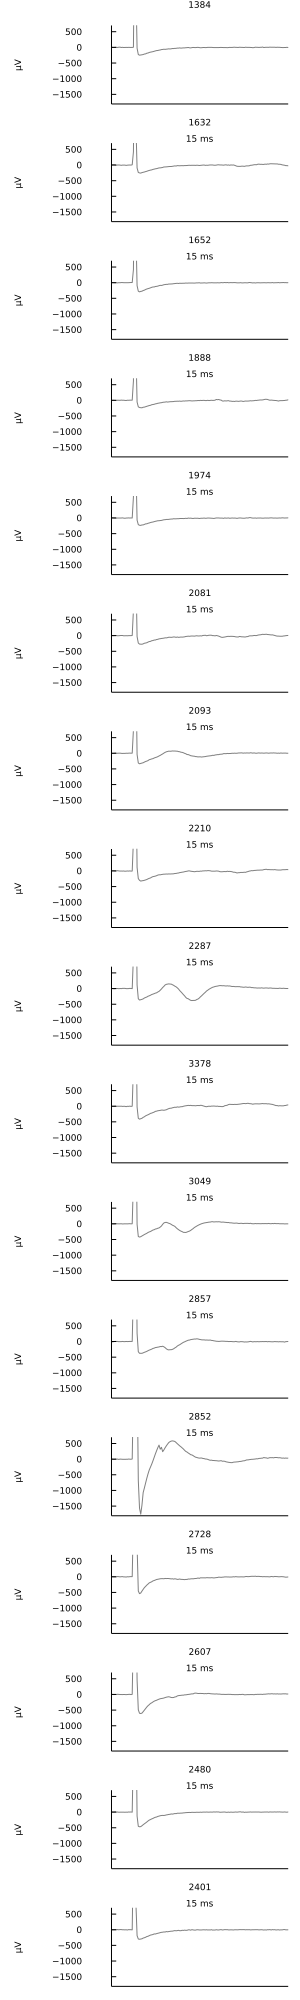

In [286]:
X = plot(Temp[aux,:]', 
    layout = (17,1), t = [:line], 
    grid = :none, 
    leg = false, 
    xlabel = "15 ms", 
    ylabel = "μV", 
    xaxis = [ ],
    wsize = ( 300, 2000),
    ylims = (xx-50,700),
    title = yy,
    guidefontsize = 6,
    tickfontsize = 6,
    left_margin = 20mm,
    titlefontsize = 6,
    bottom_margin = -2mm,
    lc = :black,
    l = 0.5,
    xlims = (72, 217),
    #guidefonthalign = :right
)


In [287]:
savefig( "okokok.svg")

In [295]:
Z = zeros( 4096 );
Seleccion = R100[ "ACD" ];
Z[ Seleccion ] .= 10;
Z[ seleccionados ] = Z[ seleccionados ] .+ 40;
Z[ R100[ "Stimulo" ] ] .= Z[ R100[ "Stimulo" ] ] .+ 10;
Zplot( Z, "W", :bluesreds )
savefig( "mapa.svg" )

In [51]:
# using MAT
# matwrite( "AllSpikes.mat", Dict( "data" => Temp ) );
# function MatSpikes( param::Dict{String, Any}, parametros::Dict{Any, Any},
#         spikes::Matrix{Float64}, MUA::Vector{Float64} )
#     matwrite( parametros[ "FILEspikes" ],
#             Dict(
#             "par" => param,
#             "threshold" => abs( parametros[ "thr" ] ),
#             "index" => reshape(
#                     ( ( parametros[ "index" ]./param[ "sr" ][ 1 ] )*1000 ),
#                         1, length( parametros[ "index" ] ) ),
#             "spikes" => spikes,
#             "psegment" => MUA,
#             "sr_psegment" => param[ "sr" ][ 1 ],
#         ); compress = true
#         );
#     println( "espigas del canal -> ", parametros[ "Qcanal" ], " listas" );
# end
# frames2ms( frames, SamplingRate ) = ( frames * 1000 ) / SamplingRate;

In [53]:
# aux = matread(
#     "/run/media/LBitn/Data/Hipocampo/Estimulacion/18-05-2021/BRWs/Results/Figures/times_AllSpikes2.mat" );
# cc = aux["cluster_class"][:,1];
# using StatsBase
# K = Int.( keys( countmap( cc ) ) );
# V = Int.( values( countmap( cc ) ) );
# grupos = [ ];
# coorders = [ ];
# for i in K
#     push!( grupos, Temp[ findall( cc .== i ), : ] );
#     push!( coorders, FinalChannels[ findall( cc .== i ) ] );
# end
# FigureGroups( coorders, [ ], :ice )

In [86]:
# using Colors

# cols = distinguishable_colors( 12, [RGB(0,0,0), RGB(1,1,1)], dropseed=true)
# #pcols = map( col -> (red(col), green(col), blue(col)), cols )

# cols[2] = cols[11]

# factor = 10
# vuelta = 1
# P = plot()
# for i = 1:10
#     ch = FinalChannels[((vuelta-1)*factor)+i];
#     P = plot!( Temp[ ((vuelta-1)*factor)+i, : ], c = cols[ i ], lab = "Canal $ch" );
#     P2 = heatmap
# end

# cols

# P

# Z = zeros( 4096 );
# Seleccion = R100[ "ACD" ];
# Z[ Seleccion ] .= 10;
# Z[ R100[ "Stimulo" ] ] .= Z[ R100[ "Stimulo" ] ] .+ 10;
# Z[xx] = 
# P2 = Zplot( Z, "W", :oxy );
# xx = FinalChannels[((vuelta-1)*factor) .+ collect( 1:10)];

1317